In [9]:
import sys, importlib
from pathlib import Path

# Core data analysis imports
import numpy as np
import pandas as pd
import scipy.stats
from scipy.stats import gaussian_kde

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Setup imports
project_root = Path().resolve().parent
sys.path.append(str(project_root))

from iowa_dream.data.data_loader import load_config
from iowa_dream.data.cleaner import load_and_clean_data
from iowa_dream.data.sample_split import create_sample_split

# Auto-reload modified modules
modules = ['iowa_dream.data', 'iowa_dream.data.data_loader', 
          'iowa_dream.data.cleaner', 'iowa_dream.data.sample_split']
          
if any(getattr(__import__(m), '__file__', None) and 
       Path(__import__(m).__file__).stat().st_mtime > __import__('time').time() - 60 
       for m in modules):
    [importlib.reload(__import__(m)) for m in modules]


In [2]:
# Example usage
data_file = project_root / load_config()['kaggle']['download_path'] / 'AmesHousing.csv'
df = load_and_clean_data(data_file)


Verifying new column names:
- order
- pid
- ms_subclass
- ms_zoning
- lot_frontage
- lot_area
- street
- alley
- lot_shape
- land_contour
- utilities
- lot_config
- land_slope
- neighborhood
- condition_1
- condition_2
- bldg_type
- house_style
- overall_qual
- overall_cond
- year_built
- year_remod_add
- roof_style
- roof_matl
- exterior_1st
- exterior_2nd
- mas_vnr_type
- mas_vnr_area
- exter_qual
- exter_cond
- foundation
- bsmt_qual
- bsmt_cond
- bsmt_exposure
- bsmtfin_type_1
- bsmtfin_sf_1
- bsmtfin_type_2
- bsmtfin_sf_2
- bsmt_unf_sf
- total_bsmt_sf
- heating
- heating_qc
- central_air
- electrical
- 1st_flr_sf
- 2nd_flr_sf
- low_qual_fin_sf
- gr_liv_area
- bsmt_full_bath
- bsmt_half_bath
- full_bath
- half_bath
- bedroom_abvgr
- kitchen_abvgr
- kitchen_qual
- totrms_abvgrd
- functional
- fireplaces
- fireplace_qu
- garage_type
- garage_yr_blt
- garage_finish
- garage_cars
- garage_area
- garage_qual
- garage_cond
- paved_drive
- wood_deck_sf
- open_porch_sf
- enclosed_porch
- 

In [3]:
# Check if PID column contains unique IDs
print(f"Total number of rows: {len(df)}")
print(f"Number of unique PIDs: {df['pid'].nunique()}")
print(f"Are all PIDs unique? {df['pid'].is_unique}")

Total number of rows: 2930
Number of unique PIDs: 2930
Are all PIDs unique? True


In [4]:
# Check for duplicate rows across all columns
duplicate_rows = df.duplicated()
num_duplicates = duplicate_rows.sum()

print(f"\nNumber of completely duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("\nDuplicate rows:")
    print(df[duplicate_rows])

# Check specifically for rows with same values but different PIDs/Order
print("\nChecking for duplicates excluding PID and Order columns:")
duplicate_content = df.drop(['pid', 'order'], axis=1).duplicated()
num_content_duplicates = duplicate_content.sum()

print(f"Number of rows with identical values (excluding PID/Order): {num_content_duplicates}")

if num_content_duplicates > 0:
    content_duplicate_indices = df[duplicate_content].index
    print("\nRows with identical values (showing with PID/Order):")
    print(df.loc[content_duplicate_indices])




Number of completely duplicate rows: 0

Checking for duplicates excluding PID and Order columns:
Number of rows with identical values (excluding PID/Order): 0


In [5]:
# Create train/test split
df = create_sample_split(df, "pid")

# Display split information  
print("\nSplit sizes:")
print(df['sample'].value_counts())
print("\nSplit proportions:") 
print(df['sample'].value_counts(normalize=True))





Split sizes:
sample
train    2448
test      482
Name: count, dtype: int64

Split proportions:
sample
train    0.835495
test     0.164505
Name: proportion, dtype: float64


In [6]:
# Split data into train and test sets based on sample column
train = df[df['sample'] == 'train'].copy()
test = df[df['sample'] == 'test'].copy()

print("Training set shape:", train.shape)
print("Test set shape:", test.shape)


Training set shape: (2448, 83)
Test set shape: (482, 83)


In [7]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 2448 entries, 0 to 2929
Data columns (total 83 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   order            2448 non-null   int64  
 1   pid              2448 non-null   int64  
 2   ms_subclass      2448 non-null   int64  
 3   ms_zoning        2448 non-null   object 
 4   lot_frontage     2037 non-null   float64
 5   lot_area         2448 non-null   int64  
 6   street           2448 non-null   object 
 7   alley            170 non-null    object 
 8   lot_shape        2448 non-null   object 
 9   land_contour     2448 non-null   object 
 10  utilities        2448 non-null   object 
 11  lot_config       2448 non-null   object 
 12  land_slope       2448 non-null   object 
 13  neighborhood     2448 non-null   object 
 14  condition_1      2448 non-null   object 
 15  condition_2      2448 non-null   object 
 16  bldg_type        2448 non-null   object 
 17  house_style      24

Price Range:
- Minimum: $12,789
- Maximum: $755,000

Key Statistics:
- Mean: $181,760
- Median: $161,000
- Standard Deviation: $81,049

Price Range Distribution (%):
saleprice
<$100k          8.7
$100k-$200k    61.8
$200k-$300k    21.2
$300k-$400k     6.0
>$400k          2.3


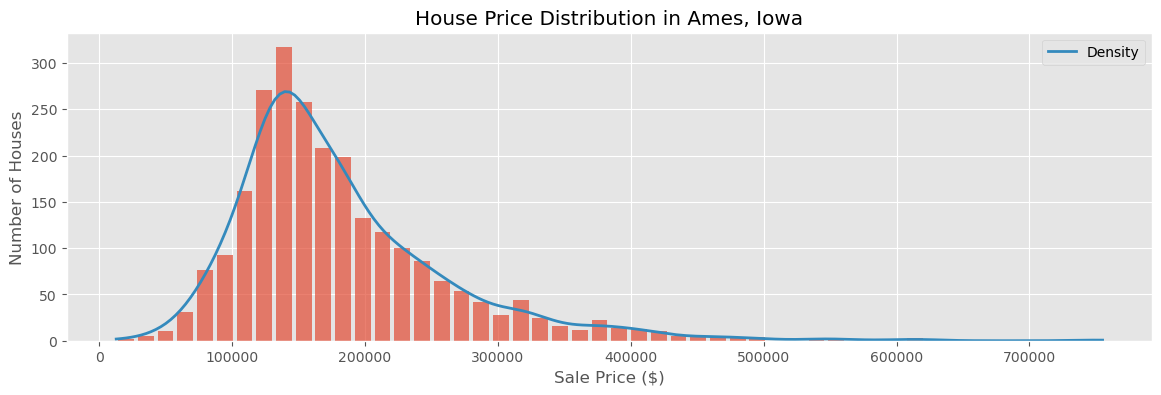

In [19]:
# Analyze house price distribution
print('Price Range:')
print('- Minimum: ${:,.0f}'.format(train.saleprice.min()))
print('- Maximum: ${:,.0f}'.format(train.saleprice.max()))
print('\nKey Statistics:')
print('- Mean: ${:,.0f}'.format(train.saleprice.mean()))
print('- Median: ${:,.0f}'.format(train.saleprice.median()))
print('- Standard Deviation: ${:,.0f}'.format(train.saleprice.std()))

# Show price range distribution
price_ranges = pd.cut(train.saleprice, 
                     bins=[0, 100000, 200000, 300000, 400000, float('inf')],
                     labels=['<$100k', '$100k-$200k', '$200k-$300k', '$300k-$400k', '>$400k'])
print('\nPrice Range Distribution (%):')
print(price_ranges.value_counts(normalize=True).mul(100).round(1).sort_index().to_string())

# Create histogram with density curve
plt.figure(figsize=(14,4))
plt.hist(train.saleprice, bins=50, rwidth=.8, alpha=0.7)
density = gaussian_kde(train.saleprice)
xs = np.linspace(train.saleprice.min(), train.saleprice.max(), 200)
density_scaled = density(xs) * len(train.saleprice) * (train.saleprice.max() - train.saleprice.min())/50
plt.plot(xs, density_scaled, linewidth=2, label='Density')
plt.title('House Price Distribution in Ames, Iowa')
plt.xlabel('Sale Price ($)')
plt.ylabel('Number of Houses')
plt.legend()
plt.show()


Available columns:
['order', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'paved_

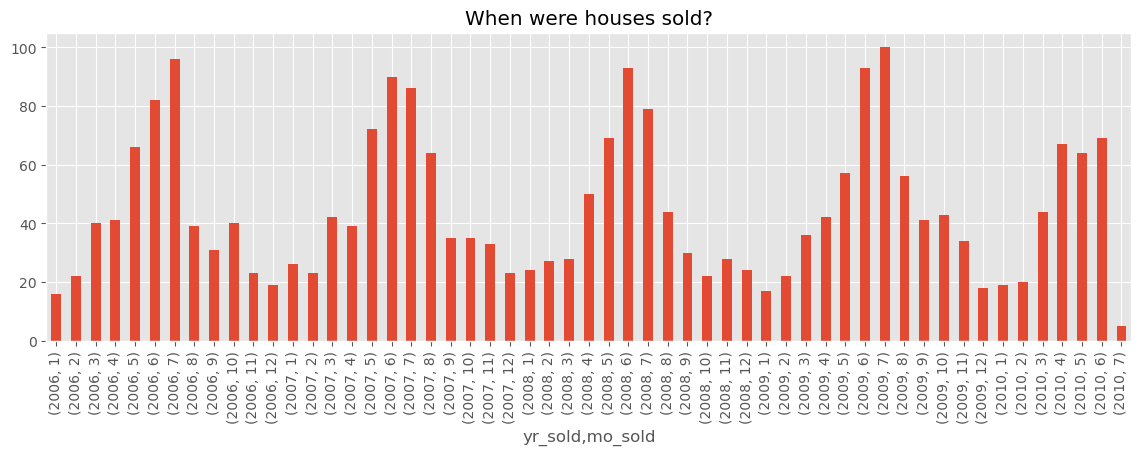

In [30]:
# The error shows 'yrsold' column doesn't exist
# Let's check the actual column names in the dataframe
print("Available columns:")
print(train.columns.tolist())

# The correct column names are likely 'yr_sold' and 'mo_sold'
train.groupby(['yr_sold','mo_sold']).pid.count().plot(kind='bar', figsize=(14,4))
plt.title('When were houses sold?') # Also fixed typo in title
plt.show()

In [38]:
# Analyze all columns: missing data, data types, and value distributions
total = df.isnull().sum()
percent = (df.isnull().sum()/df.isnull().count())
dtypes = df.dtypes
is_categorical = df.dtypes.apply(lambda x: 'categorical' if x == 'object' else 'numerical')

# Get unique values for categorical and ranges for numerical
def get_value_info(col):
    if train[col].dtype == 'object':
        unique_vals = sorted(train[col].dropna().unique())
        return f"{len(unique_vals)} unique values: {', '.join(map(str, unique_vals))}"
    else:
        val_range = train[col].max() - train[col].min()
        unique_count = len(train[col].unique())
        # Add note if numerical column might be categorical
        categorical_hint = " (Possible categorical: few unique values)" if unique_count < 15 else ""
        return f"Range: {train[col].min():.2f} to {train[col].max():.2f} ({unique_count} unique values){categorical_hint}"

value_info = {col: get_value_info(col) for col in train.columns}

# Create comprehensive DataFrame with all column information
column_analysis = pd.concat([
    total, 
    percent, 
    dtypes,
    is_categorical,
    pd.Series(value_info)
], axis=1, keys=['Total Missing', 'Percent Missing', 'Data Type', 'Variable Type', 'Value Information'])

# Sort by percent missing for better overview and display full table
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Don't wrap long strings
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

print("Complete Column Analysis (sorted by missing values):")
display(column_analysis.sort_values('Percent Missing', ascending=False))

# Additional summary
print("\nSummary:")
print(f"Total columns: {len(train.columns)}")
print(f"Categorical columns: {(is_categorical == 'categorical').sum()}")
print(f"Numerical columns: {(is_categorical == 'numerical').sum()}")
print(f"Columns with missing values: {(total > 0).sum()}")

Complete Column Analysis (sorted by missing values):


,Total Missing,Percent Missing,Data Type,Variable Type,Value Information
pool_qc,2917,0.995563,object,categorical,"4 unique values: Ex, Fa, Gd, TA"
misc_feature,2824,0.963823,object,categorical,"4 unique values: Gar2, Othr, Shed, TenC"
alley,2732,0.932423,object,categorical,"2 unique values: Grvl, Pave"
fence,2358,0.804778,object,categorical,"4 unique values: GdPrv, GdWo, MnPrv, MnWw"
mas_vnr_type,1775,0.605802,object,categorical,"4 unique values: BrkCmn, BrkFace, CBlock, Stone"
fireplace_qu,1422,0.485324,object,categorical,"5 unique values: Ex, Fa, Gd, Po, TA"
lot_frontage,490,0.167235,float64,numerical,Range: 21.00 to 313.00 (124 unique values)
garage_cond,159,0.054266,object,categorical,"5 unique values: Ex, Fa, Gd, Po, TA"
garage_yr_blt,159,0.054266,float64,numerical,Range: 1896.00 to 2207.00 (102 unique values)
garage_finish,159,0.054266,object,categorical,"3 unique values: Fin, RFn, Unf"



Summary:
Total columns: 83
Categorical columns: 44
Numerical columns: 39
Columns with missing values: 27
